In [208]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from copy import deepcopy
from os.path import join, isdir, exists
import json
import pandas as pd
import pickle
from scipy.io import wavfile
from syllable_cluster import *

from ipywidgets.widgets import FloatProgress
from IPython.display import display

import sys

sys.path.append('../model')

from song_model import SongModel

sns.set_palette('colorblind')
%matplotlib notebook
import itertools

In [336]:
main_path = '../model/res/diversity_weight/seed{}+big_ba+3_conc+3_day_conc+{}_diversity_weight+small_bloat_weight/'
rds = dict()
songlogs = dict()

for seed, div in itertools.product(range(40), [1, 125, 15, 2, 3, 10]):
    if not isdir(main_path.format(seed, div)) or not exists(join(main_path.format(seed, div), 'data.pkl')):
        continue
    path = main_path.format(seed, div)
    with open(join(path, 'data.pkl'), 'rb') as f:
            songlogs[seed, div] = pickle.load(f)
    root_data = [item[1] for item in songlogs[seed, div] if item[0] == 'root']
    for i in range(len(root_data)):
        root_data[i]['day'] = i//2+1
        if root_data[i]['moment'] in ['Start', 'AfterNight']:
            root_data[i]['moment'] = 'morning'
        else:
            root_data[i]['moment'] = 'evening'
    rds[seed, div] = pd.DataFrame(root_data)

sr, tutor = wavfile.read(join(path, 'tutor.wav'))

In [337]:
data = []
for (seed, div), df in rds.items():
    a = df.query('moment == "morning"').iloc[1:]['scores'] 
    b = df.query('moment == "evening"').iloc[:-1]['scores']
    unlearning = np.mean(np.array(a.map(np.mean)) - np.array(b.map(np.mean)))
    end = np.mean(df.iloc[-1]['scores'])
    sim  = bsa.similarity(df.iloc[-1]['songs'][np.argmin(df.iloc[-1]['scores'])].gen_sound(), tutor)['similarity']
    div_s = div
    while div_s > 10:
        div_s /= 10
    data.append({'bird': seed * 1000 + div, 'div': div_s, 'night_loss': unlearning, 'end': end, 'sim': sim})

In [338]:
data_df = pd.DataFrame(data)
data_df.sort_values('sim')

,bird,div,end,night_loss,sim
9,1,1.00,198.840792,27.204105,0.113002
20,2,2.00,168.611223,28.226766,0.157171
18,1125,1.25,167.475025,30.065018,0.227097
10,9010,10.00,204.955859,33.642237,0.231067
4,10001,1.00,201.893374,39.342340,0.341266
3,10,10.00,187.483852,28.047257,0.347494
7,10003,3.00,175.534454,33.594239,0.429355
21,10002,2.00,182.141637,40.640535,0.430546
13,8001,1.00,185.220647,30.998469,0.456079
14,125,1.25,175.635482,34.661487,0.476650


<IPython.core.display.Javascript object>


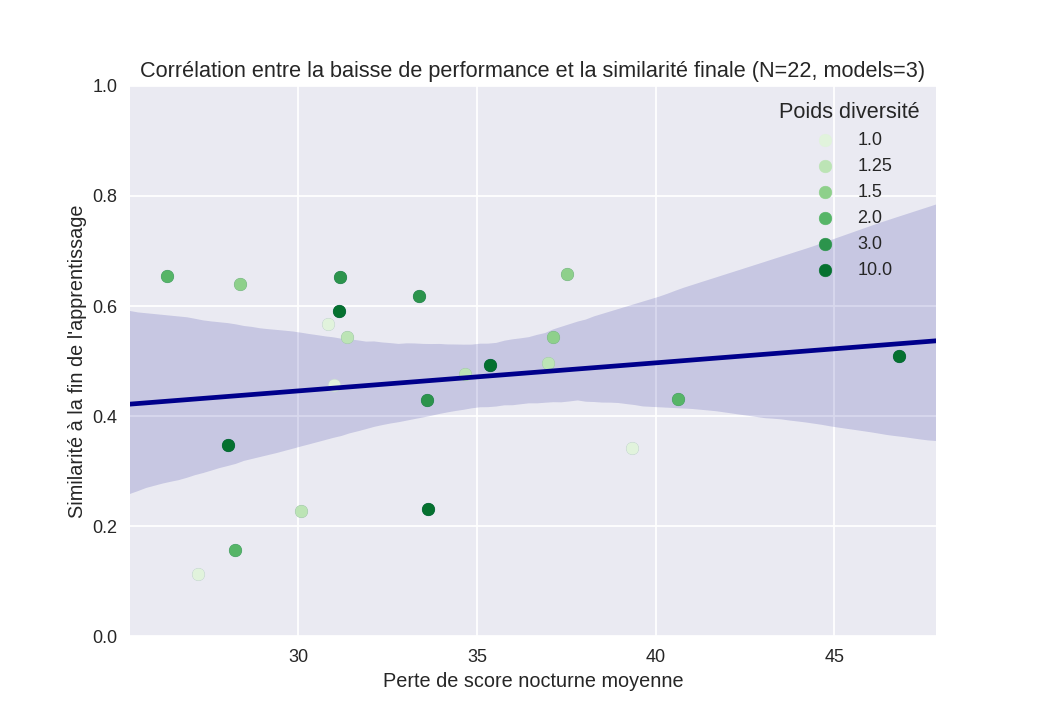

In [339]:
sns.set_context('talk')
plt.figure()
with sns.color_palette('Greens', 6):
    ax = sns.regplot(x='night_loss', y='sim', data=data_df, color='darkblue', marker='o')
    for div in sorted(data_df['div'].unique()):
        ax.scatter(data_df.query('div == {}'.format(div))['night_loss'], data_df.query('div == {}'.format(div))['sim'], label='{}'.format(div))
    ax.legend(title='Poids diversité')
    ax.set_ylabel('Similarité à la fin de l\'apprentissage')
    ax.set_xlabel('Perte de score nocturne moyenne')
    ax.set_ylim((0, 1))
    ax.set_title('Corrélation entre la baisse de performance et la similarité finale (N={}, models=3)'.format(len(data_df)))
plt.show()

<IPython.core.display.Javascript object>


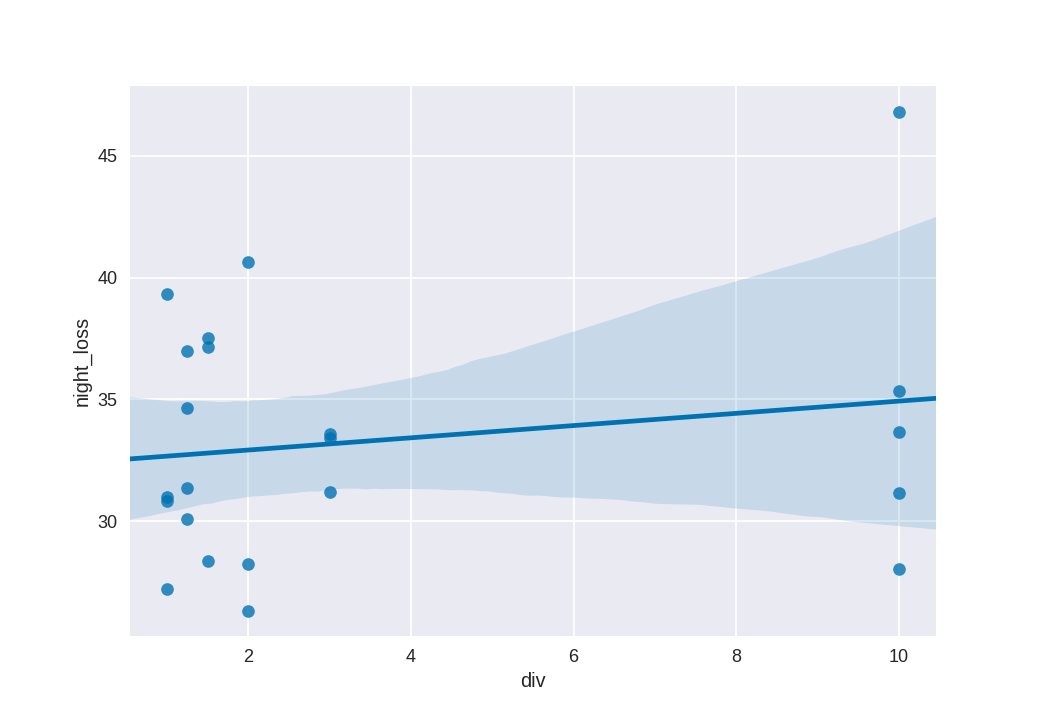

(0.18240440019961496, 0.4165265880797574)


In [340]:
plt.figure()
data_df['logdiv'] = data_df['div'].apply(np.log)
sns.regplot(data=data_df, x='div', y='night_loss')
print(scipy.stats.pearsonr(data_df['div'], data_df['night_loss']))

<IPython.core.display.Javascript object>


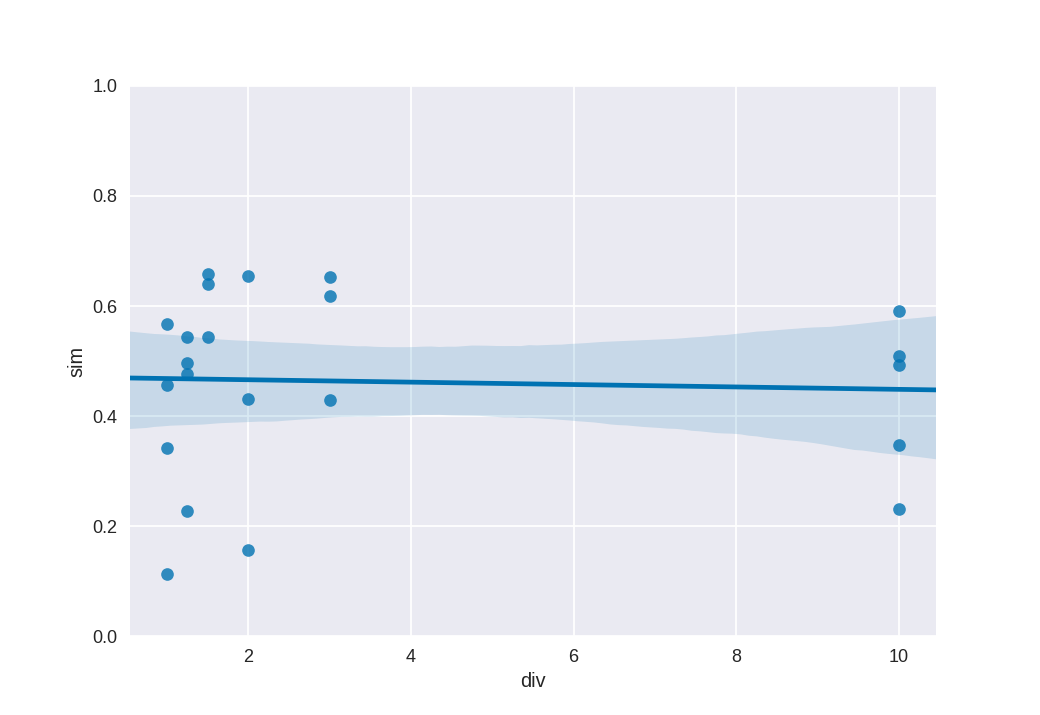

(-0.048154187572989289, 0.83148140015133909)


In [341]:
plt.figure()
data_df['logdiv'] = data_df['div'].apply(np.log)
sns.regplot(data=data_df, x='div', y='sim')
plt.ylim((0, 1))
print(scipy.stats.pearsonr(data_df['div'], data_df['sim']))

In [342]:
a = df.query('moment == "morning"').iloc[1:]['scores'] 
b = df.query('moment == "evening"').iloc[:-1]['scores']

np.array(a.map(np.mean)) - np.array(b.map(np.mean))



array([   2.9528051 ,  184.96568414,  107.32026401,   31.57312033,
          4.34269337,   -5.79711274,   41.89292087,   15.49495596,
         91.28149596,   -2.14331968,   -2.18353341,   58.62363099,
         -4.70176037,   24.50510375,   13.67471571,   84.3658553 ,
         36.06048782,   29.35766534,  119.53298006,   34.62053594,
          8.59305498,   56.70461403,   75.82543571,   47.61267577,
         28.1133857 ,    1.25289769,   68.25129684,   75.34567749,
         33.80591408,  -16.74885006,   20.91495958,   87.64141543,
         39.35449671,   17.33735917,   46.11581647,   74.61758462,
         -4.74467843,   67.32797957,  -12.21514759,   29.86251277,
         67.19059829,   -0.37001601,   86.84651376,   44.58653474,
         27.04262866,   71.53626742,   25.55323466,   30.55564775,
         27.73722607])